# Curve decoding

Analysis to see if you can decode left vs right turns from individual units in M2.



For each curve ROI we get all the times the mouse crosses it and the associated firing rate (as a function of position relative to the axis).
Then for each unit we use a logistic regression model to try and decode if the mouse went left/right through the curve from the firing rates alone. 



In [1]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from fcutils.progress import track
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from fcutils.plot.figure import clean_axes
from fcutils.plot.elements import plot_mean_and_error
from fcutils.maths.signals import rolling_mean
from analysis.ephys.utils import get_recording_names, get_data, get_session_bouts, curves, get_roi_crossings

save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Writings\THESIS\Chpt4\Plots")

# print all available recordings
TARGET = "MOs"
print(get_recording_names(region=TARGET))

[2022-07-14 11:41:40,366][INFO]: Connecting root@127.0.0.1:3306
[2022-07-14 11:41:40,433][INFO]: Connected root@127.0.0.1:3306


[07/14/22 11:41:40] DEBUG    Connected to database: LOCOMOTION4                ]8;id=772681;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py\__init__.py]8;;\:]8;id=384925;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py#11\11]8;;\

['FC_220408_BAA1101192_hairpin' 'FC_220409_BAA1101192_hairpin'
 'FC_220410_BAA1101192_hairpin' 'FC_220411_BAA1101192_hairpin'
 'FC_220412_BAA1101192_hairpin' 'FC_220413_BAA1101192_hairpin'
 'FC_220414_BAA1101192_hairpin' 'FC_220415_BAA1101192_hairpin'
 'FC_220432_BAA1101192_hairpin' 'FC_220433_BAA1101192_hairpin'
 'FC_220434_BAA1101192_hairpin' 'FC_220435_BAA1101192_hairpin']


In [2]:
def frate(spikes, s, bins):
    """
        Given the s position at each frame and the frame at which spikes occurred during a ROI crossing,
        get firing rate wrt position relative to the apex.
    """
    
    n_visits_per_bin = np.histogram(s, bins=bins)[0]

    spikes_positions = [s[spike] for spike in spikes]
    nspikes_per_bin = np.histogram(spikes_positions, bins=bins)[0]

    spikes_positions = rolling_mean(spikes_positions, 5)
    nspikes_per_bin = rolling_mean(nspikes_per_bin, 5)

    frates = nspikes_per_bin / n_visits_per_bin * 60
    frates[np.isnan(frates)] = 0.0
    frates[np.isinf(frates)] = 0.0  # a spike but no frame count?
    return frates

In [3]:
ds = 2
bins = np.arange(-20, 20+ds, step=ds)


data = {
    **dict(
        name=[],  # recording name
        unit_id=[],  # unit id
        brainregion=[],  # brain region
        direction=[],  # direction (out/in)
        roi = [],  # ROI name
        label=[],  # left, right or straight
    ),
    **{s:[] for s in bins[1:]}  # firing rate at each S position bin
}


In [4]:
alldata = {}
for REC in track(get_recording_names(region=TARGET)):
    # fetch recording data
    
    alldata[REC] =  get_data(REC)

Output()

[07/14/22 11:41:46] INFO     Got 44 units for FC_220408_BAA1101192_hairpin       ]8;id=431823;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=89958;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:41:48] INFO     Got 44 units for FC_220409_BAA1101192_hairpin       ]8;id=931817;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=361364;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:41:51] INFO     Got 40 units for FC_220410_BAA1101192_hairpin       ]8;id=475276;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=883215;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:41:55] INFO     Got 40 units for FC_220411_BAA1101192_hairpin       ]8;id=26022;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=379002;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:41:59] INFO     Got 42 units for FC_220412_BAA1101192_hairpin       ]8;id=230590;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=702323;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:42:06] INFO     Got 55 units for FC_220413_BAA1101192_hairpin       ]8;id=991557;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=326495;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:42:09] INFO     Got 56 units for FC_220414_BAA1101192_hairpin       ]8;id=106222;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=415615;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:42:12] INFO     Got 52 units for FC_220415_BAA1101192_hairpin       ]8;id=197237;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=450815;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:42:15] INFO     Got 40 units for FC_220432_BAA1101192_hairpin       ]8;id=103566;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=846444;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:42:18] INFO     Got 47 units for FC_220433_BAA1101192_hairpin       ]8;id=166275;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=900219;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:42:22] INFO     Got 74 units for FC_220434_BAA1101192_hairpin       ]8;id=767373;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=401912;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/14/22 11:42:25] INFO     Got 56 units for FC_220435_BAA1101192_hairpin       ]8;id=597315;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=38571;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

In [5]:
curve_direction = dict(
    first=dict(out="right", _in="left"),
    second=dict(out="right", _in="left"),
    third=dict(out="left", _in="right"),
    fourth=dict(out="left", _in="right"),
)


for REC in get_recording_names(region=TARGET):
    # fetch recording data
    # units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
    units, left_fl, right_fl, left_hl, right_hl, body = alldata[REC]

    if units is None or not len(units):
        continue
    if TARGET == "MOs":
        units = units.loc[units.brain_region.isin(["MOs", "MOs1", "MOs2/3", "MOs5", "MOs6a", "MOs6b"])]
    else:
        units = units.loc[units.brain_region.isin(["CUN", "PPN"])]
        

    out_bouts     = get_session_bouts(REC, complete=None)
    in_bouts      = get_session_bouts(REC, direction="inbound", complete=None)
    out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
    in_crossings  = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}

    for (i, unit) in units.iterrows():
        for curve in ("second", "third", "fourth"):
            for (direction, crossings, bouts) in (("out", out_crossings[curve], out_bouts), ("_in", in_crossings[curve], in_bouts)):
                sign = 1 if direction == "out" else -1

                for i, cross in crossings.iterrows():

                    # get spikes at each bin
                    bout = bouts.iloc[cross.bout_idx]
                    s = sign * (curves[curve].s - np.array(bout.s[cross.enter_frame:cross.exit_frame]))
                    spikes = unit.spikes[(unit.spikes > cross.session_start_frame)&(unit.spikes < cross.session_end_frame)] - cross.session_start_frame

                    # get firing rate
                    cross_frate = frate(spikes, s, bins)

                    # store all data
                    data["name"].append(REC)
                    data["unit_id"].append(unit.unit_id)
                    data["brainregion"].append(unit.brain_region)
                    data["direction"].append(direction)
                    data["roi"].append(curve)
                    data["label"].append(curve_direction[curve][direction])
                    for i, bin in enumerate(bins[1:]):
                        data[bin].append(cross_frate[i])


data = pd.DataFrame(data)
data.head()

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)
c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)
c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)
c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explici

In [ ]:
# label each row by the unit/recording it belongs to
data["identifier"] = data["name"] + "+unit_" + data["unit_id"].astype(str)
n_units = len(data.identifier.unique())
print(n_units)

172


## Fit model
For each unit, try to predict L/R turn from the firing rate of the unit.

In [ ]:
# create dummy variables columns
data = data.join(pd.get_dummies(data[["label", "direction"]]))
data.head()

,name,unit_id,brainregion,direction,roi,label,-18,-16,-14,-12,...,12,14,16,18,20,identifier,label_left,label_right,direction__in,direction_out
0,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,0.0,6.0,10.000000,3.75,...,16.0,8.0,4.0,8.0,9.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1
1,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,30.0,20.0,13.333333,7.50,...,0.0,0.0,0.0,4.0,4.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1
2,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,0.0,12.0,8.000000,7.50,...,12.0,8.0,3.0,0.0,8.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1
3,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,0.0,0.0,13.333333,12.00,...,12.0,12.0,12.0,4.0,0.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1
4,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,60.0,40.0,26.666667,18.75,...,8.0,8.0,12.0,12.0,12.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1


In [ ]:
PREDICTED = "label_right"

select_cols = list(bins[1:]) + [PREDICTED]

results, shuffled_accuracies = {}, []

for unit in track(data.identifier.unique()):
    # sample L/R trials to get equal number of trials per direction
    unit_data = data.loc[data.identifier == unit]
    name = unit_data.name.iloc[0]

    side_counts = unit_data.groupby(["label"])["name"].count()

    try:
        n_selected = min(side_counts["left"], side_counts["right"])
    except:
        continue
    
    if n_selected < 10:
        continue
    left = unit_data.loc[unit_data.label == "left"].sample(n_selected)
    right = unit_data.loc[unit_data.label == "right"].sample(n_selected)

    # keep bins + label column
    unit_data = pd.concat([left, right])[select_cols].reset_index(drop=True)

    # split train/test
    X = unit_data.drop(PREDICTED, axis=1)
    y = unit_data[PREDICTED]

    # standardize columns of X
    X = (X - X.mean()) / (X.std() + 0.0001)

    # skip units with no spikes
    # if np.max(X.mean().values) < .5:
    #     continue

    # fit the model with 5x k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    kf.get_n_splits(X)
    kf_accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # scale data
        # scaler = StandardScaler()
        # scaler.fit(X_train)
        # X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

        # fit model
        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)
        kf_accuracies.append(logreg.score(X_test, y_test))


    # fit model on randomly shuffled labels
    # split X in train/test
    X_train, X_test, _, _ = train_test_split(X, y, test_size=.3, random_state=0)
    unit_shuffled_accuracies = []
    for i in range(100):
        y_shuffled = y.sample(frac=1, random_state=i)
        _, _, y_shuff_train, y_shuff_test = train_test_split(X, y_shuffled, test_size=0.3, random_state=0)

        shuffled_logreg = LogisticRegression()
        shuffled_logreg.fit(X_train, y_shuff_train)

        acc = shuffled_logreg.score(X_test, y_shuff_test)
        shuffled_accuracies.append(acc)
        unit_shuffled_accuracies.append(acc)

    # check if the model is significantly better than the shuffled labels
    tuned = np.mean(kf_accuracies) > np.percentile(unit_shuffled_accuracies, 99)

    results[unit] = dict(
        name=name,
        identifier=unit,
        model=logreg,
        accuracy=np.mean(kf_accuracies),
        # scaler=scaler,
        tuned = tuned,
        X_test=X_test,
        y_test=y_test,

    )

    # if len(results.keys()) > 100:
    #     break

print(f"Succesfully fit {len(results.keys())} models for {n_units}")

Output()

Succesfully fit 89 models for 172


# Plot results
plot accuracy histograma and ROC curve

<Figure size 1152x648 with 2 Axes>

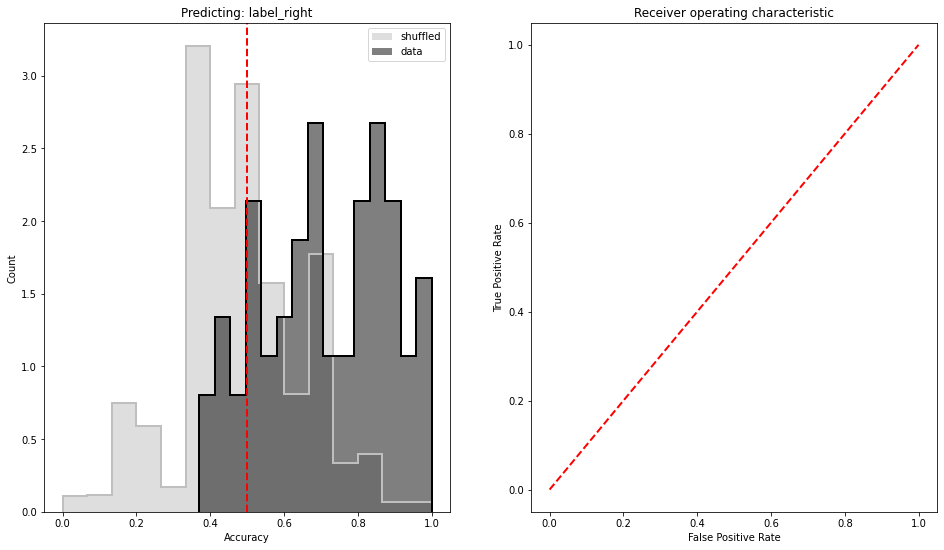

In [ ]:
TARGET = TARGET if TARGET == "MOs" else "CUN_PPN"

f, axes = plt.subplots(1, 2, figsize=(16, 9))

accuracies = [r["accuracy"] for r in results.values()]

axes[0].hist(shuffled_accuracies, density=True, bins=15, alpha=.5, color=[.75, .75, .75], label="shuffled")
axes[0].hist(shuffled_accuracies, density=True, bins=15, lw=2, histtype="step", color=[.75, .75, .75])
axes[0].hist(accuracies, density=True, bins=15, alpha=.5, color="k", label="data")
axes[0].hist(accuracies, density=True, bins=15, lw=2, histtype="step", color="k")
axes[0].legend()

# for res in results.values():
#     logit_roc_auc = roc_auc_score(res['y_test'], logreg.predict(res['X_test']))
#     fpr, tpr, thresholds = roc_curve(res['y_test'], logreg.predict_proba(res['X_test'])[:,1])

#     axes[1].plot(fpr, tpr, color="k", alpha=.5)

axes[0].set(xlabel="Accuracy", ylabel="Count", title=f"Predicting: {PREDICTED}", xlim=[-0.05, 1.05])
axes[0].axvline(0.5, lw=2, color="r", ls="--")
axes[1].plot([0, 1], [0, 1],'r--', lw=2)
_ = axes[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver operating characteristic')

# save figure
f.savefig(save_folder / f"LR_decoding_{TARGET}_accuracy_hist.svg")

In [ ]:
accuracies = np.array(accuracies)
above_66 = len(accuracies[accuracies >= 0.6])
above_90 = len(accuracies[accuracies >= 0.9])
print(f"{above_66}/{len(accuracies)} ({round(above_66/len(accuracies) * 100, 2)}%) units have accuracy > 60%")
print(f"{above_90}/{len(accuracies)} ({round(above_90/len(accuracies) * 100, 2)}%) units have accuracy > 90%")

63/89 (70.79%) units have accuracy > 60%
15/89 (16.85%) units have accuracy > 90%


Fraction tuned: 0.25842696629213485 - 23/89


<Figure size 1152x648 with 1 Axes>

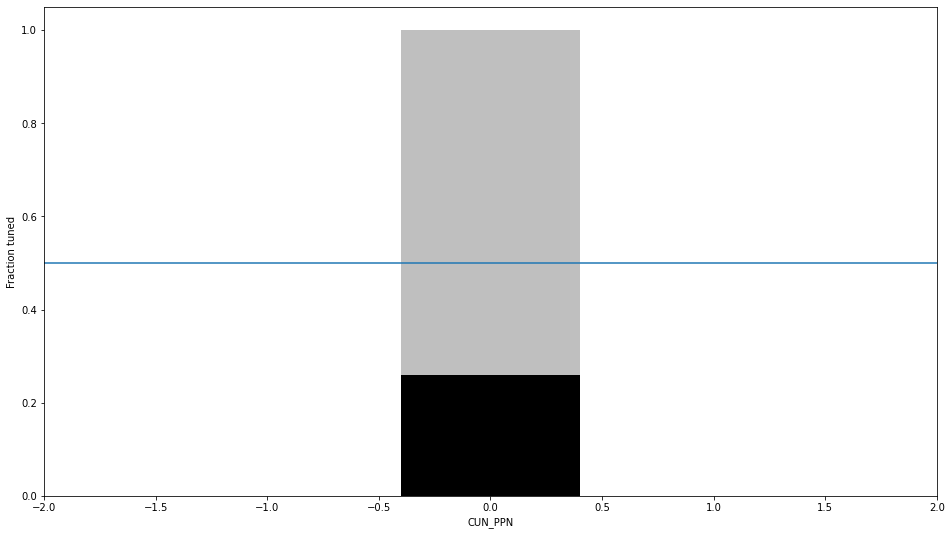

In [ ]:
# Plot number of tuned units as bar plot
f, ax = plt.subplots(1, 1, figsize=(16, 9))

N = len(results.keys())
n_tuned = len([r for r in results.values() if r["tuned"]])

print(f"Fraction tuned: {n_tuned/N} - {n_tuned}/{N}")

ax.bar(0, n_tuned/N, color="k")
ax.bar(0, (N - n_tuned)/N, bottom=(n_tuned)/N, color=[.75, .75, .75])
_ = ax.set(xlim=[-2, 2], ylabel="Fraction tuned", xlabel=TARGET)
ax.axhline(.5)


f.savefig(save_folder / f"LR_decoding_{TARGET}_n_tuned.svg")

<Figure size 1152x648 with 1 Axes>

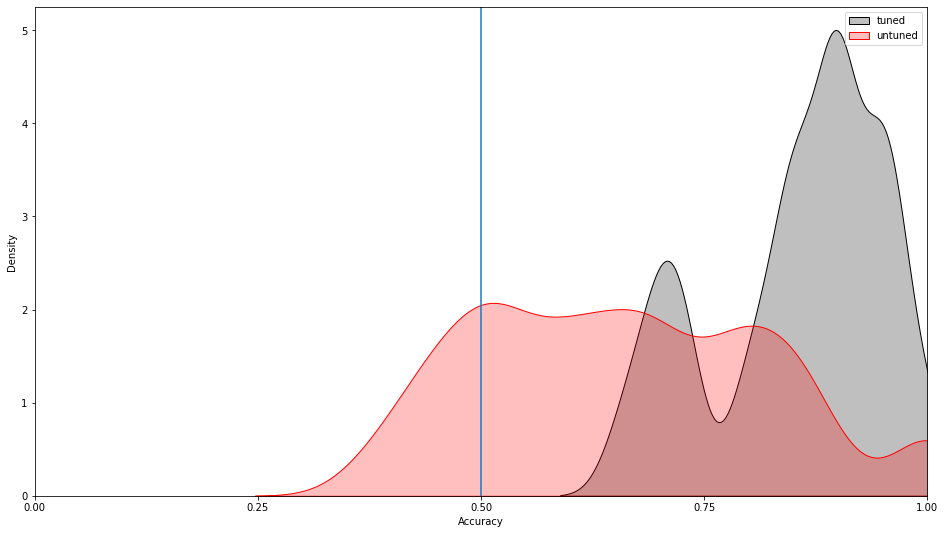

In [ ]:
# plot histogram of accuracy for tuned vs non-tuned units
import seaborn as sns
f, ax = plt.subplots(1, 1, figsize=(16, 9))

tuned_accuracies = [r["accuracy"] for r in results.values() if r["tuned"]]
untuned_accuracies = [r["accuracy"] for r in results.values() if not r["tuned"]]

# ax.hist(tuned_accuracies, density=True, bins=10, alpha=.5, color="k", label="tuned")
# ax.hist(untuned_accuracies, density=True, bins=10, alpha=.5, color="red", label="untuned")

sns.kdeplot(tuned_accuracies, shade=True, ax=ax, color="k", bw_method=.25, label="tuned")
sns.kdeplot(untuned_accuracies, shade=True, ax=ax, color="red", bw_method=.25, label="untuned")


ax.axvline(.5)
ax.set(xlim=[0, 1], xlabel="Accuracy", ylabel="Density", xticks=[0, .25, .5, .75, 1])
_ = ax.legend()

f.savefig(save_folder / f"LR_decoding_{TARGET}_accuracy_tunedvsuntuned_KDE.svg")


# Plot example unit

Plot firing rate over position for an example tuned unit

In [ ]:
from scipy import interpolate

def upsample_frames_to_ms(var):
    """
        Interpolates the values of a variable expressed in frams (60 fps)
        to values expressed in milliseconds.
    """
    t_60fps = np.arange(len(var)) / 60
    f = interpolate.interp1d(t_60fps, var)

    t_1000fps = np.arange(0, t_60fps[-1], step=1/1000)
    # t_200fps = np.arange(0, t_60fps[-1], step=1/200)
    interpolated_variable_values = f(t_1000fps)
    return interpolated_variable_values




def gaussian(x, s):
    return (
        1.0
        / np.sqrt(2.0 * np.pi * s ** 2)
        * np.exp(-(x ** 2) / (2.0 * s ** 2))
    )


def calc_firing_rate(spikes_train: np.ndarray, dt: int = 10):
    """
        Computes the firing rate given a spikes train (wether there is a spike or not at each ms).
        Using a gaussian kernel with standard deviation = dt/2 [dt is in ms]
    """
    # create kernel & get area under the curve
    k = np.array([gaussian(x, dt) for x in np.linspace(-4*dt, 4*dt, dt)])
    auc = np.trapz(k)
    k /= auc

    # get firing rate
    frate = (
        np.convolve(spikes_train, k, mode="same") / auc 
    )  

    
    return frate 


from mpl_toolkits.axes_grid1 import make_axes_locatable


def add_colorbar(ax, im, cbar_label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="15%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(cbar_label)
    return cbar


In [ ]:
# sort units based on accuracy
sorted_units = sorted(results.values(), key=lambda x: x["accuracy"], reverse=True)

best_unit = sorted_units[2]
rec, unit = best_unit["identifier"].split("+")

# load rec
units, left_fl, right_fl, left_hl, right_hl, body = alldata[rec]
out_bouts = get_session_bouts(rec, complete=None)
in_bouts = get_session_bouts(rec, direction="inbound", complete=None)

out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
in_crossings = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}

# get unit data
unit = units.loc[units.unit_id == int(unit.split("_")[-1])].iloc[0]



C:\Users\Federico\AppData\Local\Temp\ipykernel_19568\2053339253.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time_frames[spikes.astype(np.int)] = 1


<Figure size 1152x648 with 4 Axes>

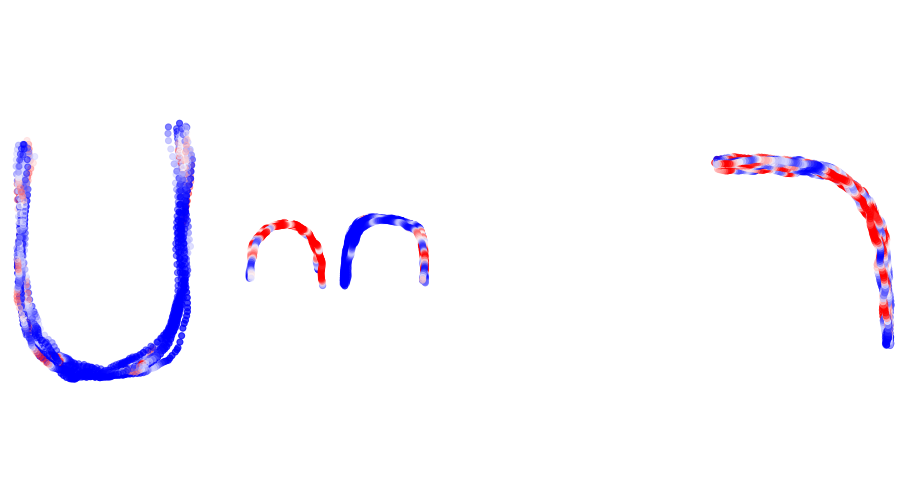

In [ ]:

f, axes = plt.subplots(1, 4, figsize=(16, 9))

for ax in axes:
    ax.axis("equal")
    ax.axis("off")

x_shift = [15, 24, 15,  5, ]
y_shift = [0, 0,  0,  10,]

CURVES = ("first", "second", "third", "fourth")
firing_rate_data = {
    "left":{curv : dict(x=[], y=[], frate=[]) for curv in CURVES},
    "right":{curv : dict(x=[], y=[], frate=[]) for curv in CURVES},
}

for i, curve in enumerate(CURVES):
    crossings_out = out_crossings[curve]
    crossings_in = in_crossings[curve]

    for c, crossings in enumerate([crossings_out, crossings_in]):
        if c == 0:
            color = "k"
            x, y = 0, 0
        else:
            color = "red"
            x, y = x_shift[i], y_shift[i]

        for _, cross in crossings.iterrows():
            bout = out_bouts.iloc[cross.bout_idx] if c  == 0 else in_bouts.iloc[cross.bout_idx]

            # get XY coord
            X = (np.array(bout.x[cross.enter_frame:cross.exit_frame]) - x)
            Y = (np.array(bout.y[cross.enter_frame:cross.exit_frame]) - y)

            # get spikes  & position in milliseconds
            spikes = unit.spikes[(unit.spikes > cross.session_start_frame)&(unit.spikes < cross.session_end_frame)] - cross.session_start_frame

            time_frames = np.zeros(int(cross.session_end_frame - cross.session_start_frame))
            time_frames[spikes.astype(np.int)] = 1

            spike_ms = upsample_frames_to_ms(time_frames)
            x_ms = upsample_frames_to_ms(X)
            y_ms = upsample_frames_to_ms(Y)

            frate = calc_firing_rate(spike_ms, dt=200)

            axes[i].scatter(x_ms[::10], y_ms[::10], c=frate[::10], cmap="bwr", vmin=0, vmax=5, alpha=.5)

            # store data
            side = list(curve_direction[curve].values())[c]
            firing_rate_data[side][curve]["x"].extend(x_ms)
            firing_rate_data[side][curve]["y"].extend(y_ms)
            firing_rate_data[side][curve]["frate"].extend(frate)

<Figure size 1152x648 with 6 Axes>

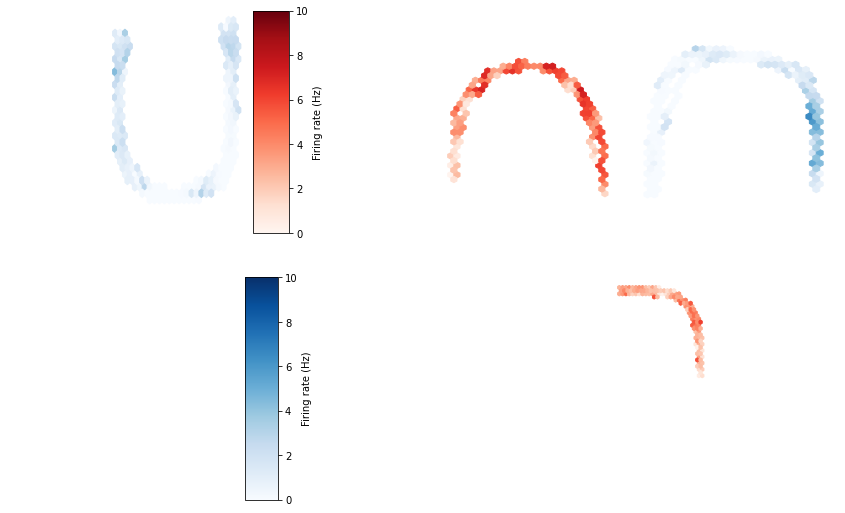

In [ ]:
# plot a heatmap of the firing rate at each curve in each direction

f, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.flatten()

for ax in axes:
    ax.axis("equal")
    ax.axis("off")


for i, side in enumerate(("left", "right")):
    cmap = "Reds" if i == 0 else "Blues"
    for j, curve in enumerate(CURVES):

        dx = x_shift[j] if i == 1 else 0
        dy = y_shift[j] if i == 1 else 0

        x = np.array(firing_rate_data[side][curve]["x"]) #  + dx
        y = np.array(firing_rate_data[side][curve]["y"]) #  + dy
        frate = np.array(firing_rate_data[side][curve]["frate"])


        im = axes[j].hexbin(x, y, frate, cmap=cmap, gridsize=25, vmin=0, vmax=10)

        # add colorbar
        if j == 0 and i == 0:
            add_colorbar(axes[0], im, "Firing rate (Hz)")

        if j == 1 and i == 1:
            add_colorbar(axes[2], im, "Firing rate (Hz)")


# save figure 
f.savefig(f"{save_folder}/LR_decoding_example_{TARGET}_{unit.unit_id}_firing_rate.svg", dpi=300)